#Q2 [P ∥ CO2 & CO3] Autoencoder (6 points)
Pick random 1000 images (Train- 900, Test-100) of 5 Superclasses of the CIFAR-100 dataset (https://
www.cs.toronto.edu/~kriz/cifar.html, https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.
gz) and train an autoencoder to regenerate the images. Apply batch normalization and plot the loss vs.
epoch training curve. Print a 5x2 grid containing 1 test image of each class, in which the first column contains
the original image and the second column contains the autoencoder output of the same image.
Now, use the latent embeddings learned in the above autoencoder to build a five-class classifier. Show
performance on train and test sets using accuracy as an evaluation metric.

In [ ]:
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
import pickle
import gzip
from google.colab import drive
import random
import keras
from keras.layers import Flatten,Dense,Conv2D,MaxPooling2D,UpSampling2D,Dropout
from keras.models import Model,load_model
from keras import Input,Sequential
from keras.layers import BatchNormalization
from keras.optimizers import RMSprop
from keras.utils import to_categorical
import tensorflow as tf
from keras.datasets import fashion_mnist
from keras.applications import VGG16
from keras.applications import VGG19
from keras.applications import ResNet50V2
from keras.applications import MobileNet
from keras.applications import EfficientNetB0
from keras.applications.mobilenet import preprocess_input
import cv2
import gc
from sklearn import preprocessing

In [ ]:

tf.config.run_functions_eagerly(True)

In [ ]:

drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [ ]:
!tar -xvf "/content/gdrive/MyDrive/ML_A3/cifar-100-python.tar.gz"

cifar-100-python/
cifar-100-python/file.txt~
cifar-100-python/train
cifar-100-python/test
cifar-100-python/meta


In [ ]:
with open("/content/cifar-100-python/train", 'rb') as data:
  train = pickle.load(data, encoding='bytes')

with open("/content/cifar-100-python/test", 'rb') as data:
  test = pickle.load(data, encoding='bytes')

with open("/content/cifar-100-python/meta", 'rb') as data:
  meta = pickle.load(data, encoding='bytes')


In [ ]:
print(train.keys())
print(len(train[b'data']))
print(train[b'data'][0])
print(len(train[b'data'][0]))


dict_keys([b'filenames', b'batch_label', b'fine_labels', b'coarse_labels', b'data'])
50000
[255 255 255 ...  10  59  79]
3072


In [ ]:
superclasses = np.unique(np.concatenate((np.array(train[b'coarse_labels']),np.array(test[b'coarse_labels'])),axis=0))
print(superclasses)


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


In [ ]:
random.seed(12223)

selected_classes = random.sample(list(superclasses), 5)
print(selected_classes)


[2, 8, 10, 18, 0]


In [ ]:
dict_of_indices = {}
for i in selected_classes:
  dict_of_indices[i]=[]
  for j in range(len(train[b'coarse_labels'])):
    if train[b'coarse_labels'][j]==i:
      dict_of_indices[i].append(j)
print(dict_of_indices)


{2: [12, 22, 70, 126, 141, 164, 167, 174, 221, 225, 246, 274, 314, 318, 324, 330, 336, 352, 362, 419, 445, 456, 460, 466, 472, 498, 510, 511, 524, 572, 582, 591, 607, 625, 649, 650, 676, 719, 727, 737, 739, 743, 751, 768, 788, 837, 864, 871, 897, 899, 907, 913, 947, 976, 1000, 1029, 1056, 1102, 1103, 1104, 1112, 1136, 1143, 1144, 1178, 1197, 1231, 1259, 1278, 1295, 1296, 1331, 1344, 1358, 1359, 1402, 1450, 1484, 1547, 1561, 1577, 1580, 1609, 1642, 1647, 1660, 1695, 1731, 1754, 1756, 1815, 1825, 1854, 1888, 1890, 1894, 1896, 1913, 1919, 1948, 1972, 2074, 2083, 2084, 2095, 2101, 2147, 2198, 2216, 2242, 2243, 2279, 2295, 2302, 2321, 2422, 2430, 2431, 2460, 2466, 2487, 2508, 2529, 2542, 2544, 2564, 2575, 2625, 2642, 2657, 2674, 2678, 2701, 2705, 2722, 2753, 2755, 2804, 2814, 2828, 2883, 2903, 2971, 2990, 2997, 3003, 3020, 3040, 3109, 3118, 3126, 3141, 3217, 3221, 3234, 3279, 3292, 3314, 3340, 3390, 3404, 3418, 3438, 3448, 3467, 3486, 3507, 3510, 3522, 3539, 3541, 3546, 3555, 3569, 3625, 36

In [ ]:

x_train = []
y_train = np.array([])
x_indices_present = []
while len(x_train)!=900:
  classChosen=selected_classes[random.randrange(len(selected_classes))]
  elementChosen = dict_of_indices[classChosen][random.randrange(len(dict_of_indices[classChosen]))]
  if elementChosen not in x_indices_present:
    y_train=np.concatenate((y_train,np.array([classChosen])),axis=0)
    x_train.append(np.array(train[b'data'][elementChosen]))
    x_indices_present.append(elementChosen)
x_train = np.array(x_train)
dict_of_indices = {}
for i in selected_classes:
  dict_of_indices[i]=[]
  for j in range(len(test[b'coarse_labels'])):
    if test[b'coarse_labels'][j]==i:
      dict_of_indices[i].append(j)
x_test = []
y_test = np.array([])
x_indices_present = []
while len(x_test)!=100:
  classChosen=selected_classes[random.randrange(len(selected_classes))]
  elementChosen = dict_of_indices[classChosen][random.randrange(len(dict_of_indices[classChosen]))]
  if elementChosen not in x_indices_present:
    y_test=np.concatenate((y_test,np.array([classChosen])),axis=0)
    x_test.append(np.array(test[b'data'][elementChosen]))
    x_indices_present.append(elementChosen)
x_test = np.array(x_test)



In [ ]:
print(type(x_train[0]))
print(len(x_train))
print(len(y_train))
print(len(x_test))
print(len(y_test))


<class 'numpy.ndarray'>
900
900
100
100


In [ ]:
x_train = x_train / np.max(x_train)
x_test = x_test / np.max(x_test)


In [ ]:
x_train = x_train.reshape(-1,3,32,32).transpose(0, 2, 3, 1)
x_test = x_test.reshape(-1,3,32,32).transpose(0, 2, 3, 1)


In [ ]:
print(x_train.shape)
print(x_test.shape)


(900, 32, 32, 3)
(100, 32, 32, 3)


In [ ]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D

def encoder(input_tensor):
    # First convolutional layer
    conv1 = Conv2D(filters=32, # 32 output channels
                   kernel_size=(3,3), # 3x3 kernel size
                   activation='relu', # ReLU activation function
                   padding='same')(input_tensor) # Same padding
    # Batch normalization layer after conv1
    bn1 = BatchNormalization()(conv1)
    # Max pooling layer after bn1
    maxpool1 = MaxPooling2D(pool_size=(2,2), padding='same')(bn1)

    # Second convolutional layer
    conv2 = Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same')(maxpool1)
    # Batch normalization layer after conv2
    bn2 = BatchNormalization()(conv2)

    # Third convolutional layer
    conv3 = Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same')(bn2)
    # Batch normalization layer after conv3
    bn3 = BatchNormalization()(conv3)
    # Max pooling layer after bn3
    maxpool2 = MaxPooling2D(pool_size=(2,2), padding='same')(bn3)

    # Fourth convolutional layer
    conv4 = Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same')(maxpool2)
    # Batch normalization layer after conv4
    bn4 = BatchNormalization()(conv4)

    # Final convolutional layer to encode the input image

    encoded_img = Conv2D(filters=16, kernel_size=(3,3), activation='sigmoid', padding='same')(conv4_layer)
    # Use sigmoid activation for the last layer to squash the pixel values between 0 and 1, making the output a binary image

    # Return the encoded image
    return encoded_img

In [ ]:
def my_decoder(encoded_img):
    # Decoder network
    conv1_layer = Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same')(encoded_img)
    conv1_layer = BatchNormalization()(conv1_layer)

    conv2_layer = Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same')(conv1_layer)
    conv2_layer = BatchNormalization()(conv2_layer)

    # Upsampling layer 1
    upsampled_layer1 = UpSampling2D(size=(2,2))(conv2_layer)

    conv3_layer = Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same')(upsampled_layer1)
    conv3_layer = BatchNormalization()(conv3_layer)

    conv4_layer = Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same')(conv3_layer)
    conv4_layer = BatchNormalization()(conv4_layer)

    # Upsampling layer 2
    upsampled_layer2 = UpSampling2D(size=(2,2))(conv4_layer)

    decoded_img = Conv2D(filters=3, kernel_size=(3,3), activation='sigmoid', padding='same')(upsampled_layer2)
    # Use sigmoid activation for the last layer to squash the pixel values between 0 and 1, making the output a binary image

    # Return the decoded image
    return decoded_img

In [ ]:
autoEnc = my_decoder(encoder())
print(autoEnc.summary())
autoEnc.compile(optimizer = RMSprop(),loss="mean_squared_error",metrics=['mean_squared_error'])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 16)        448       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 16)       64        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        4640      
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 batch_normalization_2 (Batc  (None, 32, 32, 64)       2

In [ ]:
trackLoss = autoEnc.fit(x_train,x_train,batch_size=100,epochs=50,validation_split=0.3,callbacks = [
    keras.callbacks.ModelCheckpoint("autoencoder.h5",save_best_only=True),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=25, verbose=1),
])


/usr/local/lib/python3.9/dist-packages/tensorflow/python/data/ops/structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/50
7/7 [==============================] - 12s 299ms/step - loss: 1.0345 - mean_squared_error: 1.0345 - val_loss: 0.0701 - val_mean_squared_error: 0.0701
Epoch 2/50
7/7 [==============================] - 1s 159ms/step - loss: 0.8207 - mean_squared_error: 0.8207 - val_loss: 0.0668 - val_mean_squared_error: 0.0668
Epoch 3/50
7/7 [==============================] - 1s 161ms/step - loss: 0.7749 - mean_squared_error: 0.7749 - val_loss: 0.0573 - val_mean_squared_error: 0.0573
Epoch 4/50
7/7 [==============================] - 1s 159ms/step - loss: 0.7525 - mean_squared_error: 0.7525 - val_loss: 0.0564 - val_mean_squared_error: 0.0564
Epoch 5/50
7/7 [==============================] - 1s 151ms/step - loss: 0.7227 - mean_squared_error: 0.7227 - val_loss: 0.0560 - val_mean_squared_error: 0.0560
Epoch 6/50
7/7 [==============================] - 1s 131ms/step - loss: 0.7004 - mean_squared_error: 0.7004 - val_loss: 0.0574 - val_mean_squared_error: 0.0574
Epoch 7/50
7/7 [=======================

In [ ]:
with open('autoencoder.pkl','wb') as data:
  pickle.dump(trackLoss.history,data)


In [ ]:
with open('autoencoder.pkl','rb') as data:
  trackLoss = pickle.load(data)

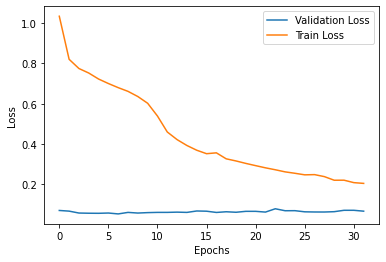

In [ ]:
plt.plot(trackLoss['val_loss'])
plt.plot(trackLoss['loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Validation Loss', 'Train Loss'])
plt.show()


In [ ]:
autoEnc = load_model("autoencoder.h5")


In [ ]:
len(np.unique(y_train))

5

In [ ]:
indexes_taken = {}
for i in selected_classes:
  indexes_taken[i]=[]
  for j in range(len(y_test)):
    if y_test[j]==i:
      indexes_taken[i].append(j)
print(indexes_taken)


{2: [0, 13, 19, 24, 26, 28, 32, 34, 43, 46, 48, 58, 60, 67, 69, 70, 71, 73, 82, 92, 97], 8: [10, 14, 15, 17, 18, 22, 31, 37, 44, 57, 59, 62, 75, 81, 87, 90, 94, 99], 10: [4, 7, 16, 23, 35, 36, 38, 39, 40, 42, 45, 51, 56, 61, 63, 65, 72, 74, 76, 80, 83, 89, 93, 96, 98], 18: [3, 8, 11, 21, 27, 30, 41, 47, 49, 50, 54, 55, 77, 78, 84, 85, 86, 91], 0: [1, 2, 5, 6, 9, 12, 20, 25, 29, 33, 52, 53, 64, 66, 68, 79, 88, 95]}


In [ ]:
y_pred = autoEnc.predict(x_test)


4/4 [==============================] - 0s 64ms/step


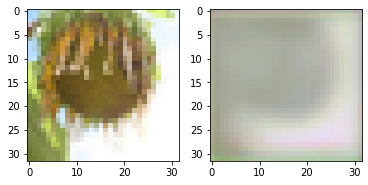

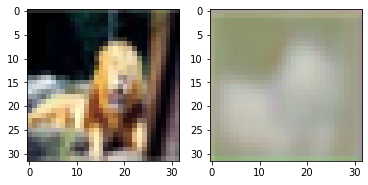

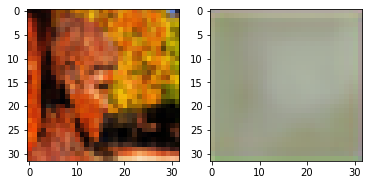

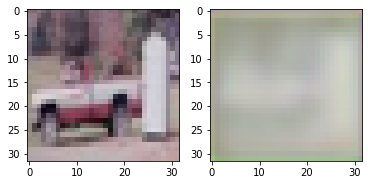

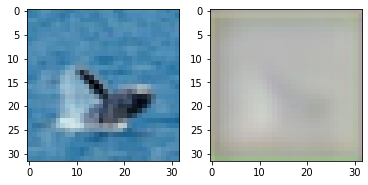

In [ ]:
y_pred = y_pred/np.max(y_pred)
for j in selected_classes:
  fig, ax = plt.subplots(1,2)
  indexChosen = indexes_taken[j][random.randrange(len(indexes_taken[j]))]
  ax[0].imshow(x_test[indexChosen])
  ax[1].imshow(y_pred[indexChosen])
  plt.show()
  

In [ ]:
print(np.min(y_pred))

0.41315737


In [ ]:
dict_of_indices = {}
for i in range(len(selected_classes)):
  dict_of_indices[selected_classes[i]] = i
print(dict_of_indices)


{2: 0, 8: 1, 10: 2, 18: 3, 0: 4}


In [ ]:
y_train_labelled = []
for i in y_train:
  y_train_labelled.append(dict_of_indices[i])
y_test_labelled = []
for i in y_test:
  y_test_labelled.append(dict_of_indices[i])
print(len(y_train_labelled))
print(len(y_test_labelled))


900
100


In [ ]:

y_train_labelled = to_categorical(y_train_labelled)
y_test_labelled = to_categorical(y_test_labelled)


In [ ]:
print(y_test_labelled)

[[1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0.

In [ ]:
def classifier(cl):
  cl.add(Flatten())
  cl.add(Dense(128, activation='relu'))
  cl.add(Dense(64, activation='relu'))
  cl.add(Dense(5, activation='softmax'))
  return cl


In [ ]:
classifier = classifier(encoding())


In [ ]:
print(classifier.summary())

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 32, 32, 16)        448       
                                                                 
 batch_normalization_12 (Bat  (None, 32, 32, 16)       64        
 chNormalization)                                                
                                                                 
 conv2d_13 (Conv2D)          (None, 32, 32, 32)        4640      
                                                                 
 batch_normalization_13 (Bat  (None, 32, 32, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_14 (Conv2D)          (None, 32, 32, 64)        18496     
                                                                 
 batch_normalization_14 (Bat  (None, 32, 32, 64)     

In [ ]:
for i in range(13):
  classifier.layers[i].set_weights(autoEnc.layers[i].get_weights())
  classifier.layers[i].trainable = False


In [ ]:
classifier.compile(optimizer = 'adam',loss="categorical_crossentropy",metrics=['accuracy'])


In [ ]:
with open('classifier.pkl','rb') as data:
  trackLossClasifier = pickle.load(data)

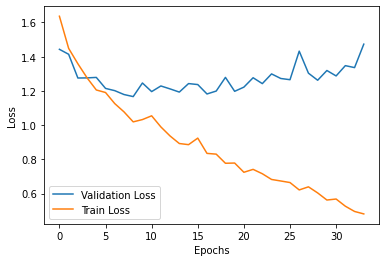

In [ ]:
plt.plot(trackLossClasifier['val_loss'])
plt.plot(trackLossClasifier['loss'])
plt.legend(['Validation Loss', 'Train Loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()


In [ ]:
classifier = load_model("Classifier.h5")

In [ ]:
print("Training accuracy is "+str((classifier.evaluate(x_train,y_train_labelled))[1]*100))
print("Test accuracy is "+str((classifier.evaluate(x_test,y_test_labelled))[1]*100))


29/29 [==============================] - 2s 51ms/step - loss: 1.0244 - accuracy: 0.6056
Training accuracy is 60.5555534362793
4/4 [==============================] - 0s 62ms/step - loss: 1.1475 - accuracy: 0.6000
Test accuracy is 60.00000238418579


#Q3 [P ∥ CO3 & C4] SVM (10 points)
Use the following SVM strategies to classify sapodillas from kiwi for the dataset available here1
. For each
strategy, plot the learned decision boundary. Use an appropriate evaluation metric to present the test scores.
(a) Linear SVM
(b) Polynomial SVM
(c) Kernel SVM
Finally, write the individual and combined inferences of the obtained results.

In [ ]:

df = pd.read_csv('/content/gdrive/MyDrive/ML_A3/Sapodillas_and_Kiwis_MLA3.csv')

In [ ]:
x = df[['Weight','Size']]

y = df['Class']

x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.3,random_state=15)
x_of_df = x.copy()
y_of_df = y.copy()


In [ ]:
# normalising the data
for col in x_train.columns:
  if col=='Class':
    continue
  # print(col)
  x_test[col]=(x_test[col] - x_train[col].min()) / (x_train[col].max()- x_train[col].min())
  x_of_df[col]=(x_of_df[col] - x_train[col].min()) / (x_of_df[col].max()- x_train[col].min())
  x_train[col]=(x_train[col] - x_train[col].min()) / (x_train[col].max()- x_train[col].min())

# normalising the data based on the training data

In [ ]:
print(x_train)
# printing the training data
print(y_train)

    Weight      Size
1      0.4  0.112360
2      0.0  0.044944
39     0.8  0.573034
6      0.5  0.870787
26     0.2  0.000000
34     0.3  0.460674
38     0.5  0.887640
37     0.9  0.825843
33     0.8  0.651685
9      0.0  0.146067
4      0.2  0.387640
29     0.6  0.702247
10     0.8  1.000000
36     0.4  0.421348
23     0.3  0.039326
13     0.3  0.258427
17     1.0  0.696629
15     0.0  0.264045
22     0.4  0.337079
21     0.5  0.460674
11     0.5  0.820225
7      1.0  0.617978
27     0.5  0.117978
28     0.9  0.696629
0      0.4  0.213483
5      0.8  0.938202
12     0.9  0.853933
8      0.9  0.758427
1     Sapodilla
2     Sapodilla
39         Kiwi
6          Kiwi
26    Sapodilla
34    Sapodilla
38         Kiwi
37         Kiwi
33         Kiwi
9     Sapodilla
4     Sapodilla
29         Kiwi
10         Kiwi
36    Sapodilla
23    Sapodilla
13    Sapodilla
17         Kiwi
15    Sapodilla
22    Sapodilla
21    Sapodilla
11         Kiwi
7          Kiwi
27    Sapodilla
28         Kiwi
0     S

In [ ]:
classifier = svm.SVC(kernel ='linear', C = 1).fit(x_train, y_train)

y_pred = classifier.predict(x_test)
linear_acc_score = accuracy_score(y_test, y_pred)
print("Accuracy score for linear SVM "+str(linear_acc_score))


Accuracy score for linear SVM 1.0


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


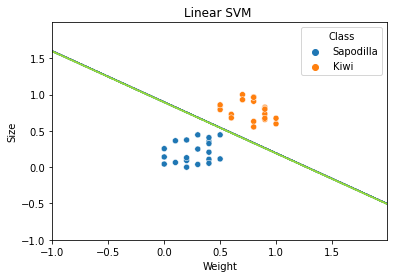

In [ ]:

min_wt, max_wt = x_of_df['Weight'].min() - 1, x_of_df['Weight'].max() + 1
min_size, max_size = x_of_df['Size'].min() - 1, x_of_df['Size'].max() + 1
x_axis_val, y_axis_val = np.meshgrid(np.arange(min_wt, max_wt, 0.005), np.arange(min_size, max_size, 0.005))
boundary = classifier.predict(np.c_[x_axis_val.ravel(), y_axis_val.ravel()])

boundary = preprocessing.LabelEncoder().fit_transform(boundary)
boundary = boundary.reshape(x_axis_val.shape)
plt.contour(x_axis_val, y_axis_val, boundary)
plt.xlabel('Weight')
plt.ylabel('Size')
plt.title('Linear SVM ')
sns.scatterplot(x=x_of_df['Weight'], y=x_of_df['Size'], hue=y)

plt.show()

In [ ]:
print(np.array(y_pred))
print(np.array(y_test))


['Kiwi' 'Sapodilla' 'Sapodilla' 'Sapodilla' 'Sapodilla' 'Kiwi' 'Kiwi'
 'Kiwi' 'Sapodilla' 'Kiwi' 'Kiwi' 'Sapodilla']
['Kiwi' 'Sapodilla' 'Sapodilla' 'Sapodilla' 'Sapodilla' 'Kiwi' 'Kiwi'
 'Kiwi' 'Sapodilla' 'Kiwi' 'Kiwi' 'Sapodilla']


In [ ]:
from sklearn.model_selection import KFold
from sklearn import svm
from sklearn.metrics import accuracy_score
import numpy as np

# Set up a KFold cross-validation object with 5 splits
kFold = KFold(n_splits=5)

# Initialize an empty list to store the accuracy scores for each fold
accuracy_scores = []

# Iterate through each fold
for i, (train_index, test_index) in enumerate(kFold.split(x_of_df)):
  
  # Initialize empty lists to store the training and testing data for this fold
  x_train_k = []
  y_train_k = []
  x_test_k = []
  y_test_k = []
  
  # Retrieve the training and testing data for this fold from the input data
  for j in train_index:
    x_train_k.append(np.array(x_of_df.loc[j]))
    y_train_k.append(np.array(y_of_df.loc[j]))
  for j in test_index:
    x_test_k.append(np.array(x_of_df.loc[j]))
    y_test_k.append(np.array(y_of_df.loc[j]))
    
  # Convert the training and testing data into numpy arrays
  x_train_k = np.array(x_train_k)
  y_train_k = np.array(y_train_k)
  
  # Train a linear SVM model on the training data for this fold
  classifier = svm.SVC(kernel='linear', C=1).fit(x_train_k, y_train_k)

  # Use the trained model to predict the labels for the testing data for


  y_pred_k = classifier.predict(x_test_k)
  accuracy_scores.append(accuracy_score(y_test_k, y_pred_k))

print("5- fold cross validation accuracy score of linear SVM model is "+str(sum(accuracy_scores)/len(accuracy_scores)))



5- fold cross validation accuracy score of linear SVM model is 1.0


In [ ]:

classifier = svm.SVC(kernel ='poly', C = 1).fit(x_train, y_train)

y_pred = classifier.predict(x_test)
polynomial_acc_score = accuracy_score(y_test, y_pred)
print("Accuracy score for polynomial SVM "+str(polynomial_acc_score))


Accuracy score for polynomial SVM 1.0


In [ ]:
kFold = KFold(n_splits=5)

accuracy_scores=[]
for i, (train_index, test_index) in enumerate(kFold.split(x_of_df)):
  x_train_k= []
  y_train_k = []
  x_test_k= []
  y_test_k = []
  for j in train_index:
     
    x_train_k.append(np.array(x_of_df.loc[j]))

    y_train_k.append(np.array(y_of_df.loc[j]))
  for j in test_index:
    x_test_k.append(np.array(x_of_df.loc[j]))
    
    y_test_k.append(np.array(y_of_df.loc[j]))
  x_train_k = np.array(x_train_k)
  y_train_k = np.array(y_train_k)
  classifier = svm.SVC(kernel ='poly', C = 1).fit(x_train_k, y_train_k)
  
  y_pred_k = classifier.predict(x_test_k)
  accuracy_scores.append(accuracy_score(y_test_k, y_pred_k))

print("5- fold cross validation accuracy score of polynomial SVM model is "+str(sum(accuracy_scores)/len(accuracy_scores)))


5- fold cross validation accuracy score of polynomial SVM model is 1.0


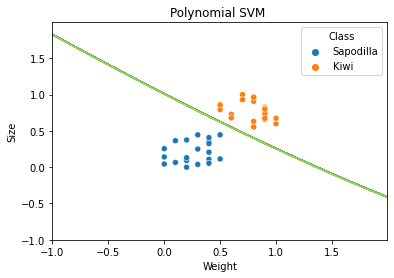

In [ ]:

min_wt, max_wt = x_of_df['Weight'].min() - 1, x_of_df['Weight'].max() + 1
min_size, max_size = x_of_df['Size'].min() - 1, x_of_df['Size'].max() + 1
x_axis_val, y_axis_val = np.meshgrid(np.arange(min_wt, max_wt, 0.005), np.arange(min_size, max_size, 0.005))
boundary = classifier.predict(np.c_[x_axis_val.ravel(), y_axis_val.ravel()])

boundary = preprocessing.LabelEncoder().fit_transform(boundary)
boundary = boundary.reshape(x_axis_val.shape)
plt.contour(x_axis_val, y_axis_val, boundary)
plt.xlabel('Weight')
plt.ylabel('Size')
plt.title('Polynomial SVM ')
sns.scatterplot(x=x_of_df['Weight'], y=x_of_df['Size'], hue=y)

plt.show()

In [ ]:

classifier = svm.SVC(kernel ='rbf', C = 1).fit(x_train, y_train)

y_pred = classifier.predict(x_test)
kernel_acc_score = accuracy_score(y_test, y_pred)
print("Accuracy score for ref kernel SVM "+str(kernel_acc_score))


Accuracy score for ref kernel SVM 1.0


In [ ]:
kFold = KFold(n_splits=5)

accuracy_scores=[]
for i, (train_index, test_index) in enumerate(kFold.split(x_of_df)):
  x_train_k= []
  y_train_k = []
  x_test_k= []
  y_test_k = []
  for j in train_index:
    x_train_k.append(np.array(x_of_df.loc[j]))
    y_train_k.append(np.array(y_of_df.loc[j]))
  for j in test_index:
    x_test_k.append(np.array(x_of_df.loc[j]))
 
    y_test_k.append(np.array(y_of_df.loc[j]))
  x_train_k = np.array(x_train_k)
  y_train_k = np.array(y_train_k)
  classifier = svm.SVC(kernel ='rbf', C = 1).fit(x_train_k, y_train_k)

  y_pred_k = classifier.predict(x_test_k)
  accuracy_scores.append(accuracy_score(y_test_k, y_pred_k))

print("5- fold cross validation accuracy score of polynomial SVM model is "+str(sum(accuracy_scores)/len(accuracy_scores)))


5- fold cross validation accuracy score of polynomial SVM model is 1.0


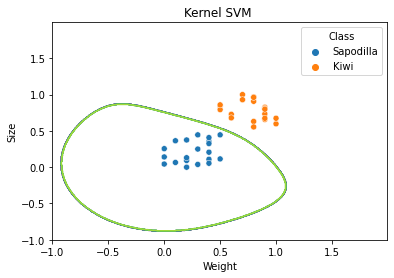

In [ ]:

min_wt, max_wt = x_of_df['Weight'].min() - 1, x_of_df['Weight'].max() + 1
min_size, max_size = x_of_df['Size'].min() - 1, x_of_df['Size'].max() + 1
x_axis_val, y_axis_val = np.meshgrid(np.arange(min_wt, max_wt, 0.005), np.arange(min_size, max_size, 0.005))
boundary = classifier.predict(np.c_[x_axis_val.ravel(), y_axis_val.ravel()])

boundary = preprocessing.LabelEncoder().fit_transform(boundary)
boundary = boundary.reshape(x_axis_val.shape)
plt.contour(x_axis_val, y_axis_val, boundary)
plt.xlabel('Weight')
plt.ylabel('Size')
plt.title('Kernel SVM ')
sns.scatterplot(x=x_of_df['Weight'], y=x_of_df['Size'], hue=y)

plt.show()

In [ ]:

print("The accuracy for kernel SVM "+str(kernel_acc_score))
print("The accuracy for polynomial SVM "+str(polynomial_acc_score))
print("The accuracy for linear SVM is "+str(linear_acc_score))

The accuracy for kernel SVM 1.0
The accuracy for polynomial SVM 1.0
The accuracy for linear SVM is 1.0


#Q4 [P ∥ CO3 & C4] Transfer Learning (20 points)
Use the FashionMNIST dataset (https://keras.io/api/datasets/fashion_mnist/) from Keras to build
one classifier each based on the following pre-trained architectures trained on IMAGENET dataset (reference:
https://keras.io/api/applications/). Remove the last layer, add your own few dense layers and the
output layer. Train only these added layers from scratch on the data. Use an appropriate evaluation metric.

In [ ]:

(x_train,y_train),(x_test,y_test)= fashion_mnist.load_data() 


In [ ]:
print(x_train.shape)


(60000, 28, 28)


In [ ]:
print(x_train.shape)


(60000, 28, 28)


In [ ]:

x_train_final=[]
x_test_final=[]
for i in x_train:
  x_train_final.append(cv2.resize(i, (56, 56)))
for i in x_test:
  x_test_final.append(cv2.resize(i, (56, 56)))
x_train_final = np.array(x_train_final)
x_test_final = np.array(x_test_final)

In [ ]:
print(x_train_final.shape)

(60000, 56, 56)


In [ ]:
x_train_final = np.dstack([x_train_final] * 3)
x_test_final = np.dstack([x_test_final] * 3)


In [ ]:
x_train_final = x_train_final.reshape(-1,56,56,3)
x_test_final = x_test_final.reshape(-1,56,56,3)


In [ ]:
print(x_train_final.shape)

(60000, 56, 56, 3)


In [ ]:
print(np.unique(y_train))
print(np.unique(y_test))


[0 1 2 3 4 5 6 7 8 9]
[0 1 2 3 4 5 6 7 8 9]


In [ ]:
y_train_labelled = to_categorical(y_train)
y_test_labelled = to_categorical(y_test)


#VGG16

In [ ]:

modVgg16 = Sequential()
modVgg16.add(VGG16(include_top=False,weights='imagenet',input_shape=(56,56, 3)))

for i in range(len(modVgg16.layers)):
  modVgg16.layers[i].trainable = False
print(modVgg16.summary())

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
Total params: 14,714,688
Trainable params: 0
Non-trainable params: 14,714,688
_________________________________________________________________
None


In [ ]:
modVgg16.add(Flatten())
modVgg16.add(Dense(128, activation='relu'))
modVgg16.add(Dense(64, activation='relu'))
modVgg16.add(Dense(10, activation='softmax'))
print(modVgg16.summary())

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten_6 (Flatten)         (None, 512)               0         
                                                                 
 dense_18 (Dense)            (None, 128)               65664     
                                                                 
 dense_19 (Dense)            (None, 64)                8256      
                                                                 
 dense_20 (Dense)            (None, 10)                650       
                                                                 
Total params: 14,789,258
Trainable params: 74,570
Non-trainable params: 14,714,688
_________________________________________________________________
None


In [ ]:
modVgg16.compile(optimizer = 'adam',loss="categorical_crossentropy",metrics=['accuracy'])


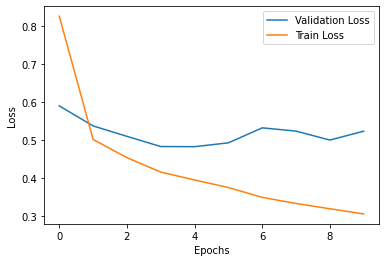

In [ ]:

with open('VGG16classifier.pkl','rb') as data:
  trackLossClasifierVgg16 = pickle.load(data)
plt.plot(trackLossClasifierVgg16['val_loss'])
plt.plot(trackLossClasifierVgg16['loss'])
plt.legend(['Validation Loss', 'Train Loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()


In [ ]:
modVgg16 = load_model("VGG16Classifier.h5")
val_vgg16 = (modVgg16.evaluate(x_test_final,y_test_labelled))[1]*100
print("Training accuracy is "+str((modVgg16.evaluate(x_train_final,y_train_labelled))[1]*100))
print("Test accuracy is "+str((modVgg16.evaluate(x_test_final,y_test_labelled))[1]*100))


/usr/local/lib/python3.9/dist-packages/tensorflow/python/data/ops/structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1875/1875 [==============================] - 55s 29ms/step - loss: 0.3874 - accuracy: 0.8611
Training accuracy is 86.1050009727478
313/313 [==============================] - 9s 28ms/step - loss: 0.4988 - accuracy: 0.8281
Test accuracy is 82.81000256538391


In [ ]:
gc.collect()

37843

#VGG19

In [ ]:

# Initialize a sequential model in Keras
modVgg19 = Sequential()

# Add the VGG19 model with pretrained weights from ImageNet, and freeze all of its layers
modVgg19.add(VGG19(include_top=False,weights='imagenet',input_shape=(56,56, 3)))
for i in range(len(modVgg19.layers)):
    modVgg19.layers[i].trainable = False
    
# Print a summary of the model architecture
print(modVgg19.summary())

# Add a flattening layer to convert the output of the VGG19 model into a 1D array
modVgg19.add(Flatten())

# Add a fully connected layer with 128 neurons and ReLU activation
modVgg19.add(Dense(128, activation='relu'))

# Add a second fully connected layer with 64 neurons and ReLU activation
modVgg19.add(Dense(64, activation='relu'))

# Add a final fully connected layer with 10 neurons and softmax activation
modVgg19.add(Dense(10, activation='softmax'))

# Print a summary of the model architecture
print(modVgg19.summary())

# Compile the model using the Adam optimizer, categorical crossentropy loss, and accuracy as a metric
modVgg19.compile(optimizer = 'adam',loss="categorical_crossentropy",metrics=['accuracy'])


Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 1, 1, 512)         20024384  
                                                                 
Total params: 20,024,384
Trainable params: 0
Non-trainable params: 20,024,384
_________________________________________________________________
None
Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 1, 1, 512)         20024384  
                                                                 
 flatten_7 (Flatten)         (None, 512)               0         
                                                                 
 dense_21 (Dense)            (None, 128)               65664     
                                                                 
 dense_22 (De

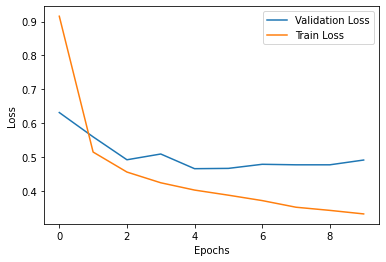

In [ ]:

import pickle
import matplotlib.pyplot as plt

# Load the training history data from a pickle file
with open('VGG19classifier.pkl', 'rb') as f:
    trackLossClassifierVgg19 = pickle.load(f)

# Plot the validation and training loss curves over time
plt.plot(trackLossClassifierVgg19['val_loss'])
plt.plot(trackLossClassifierVgg19['loss'])
plt.legend(['Validation Loss', 'Train Loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()


In [ ]:
modVgg19 = load_model("VGG19Classifier.h5")
val_vgg19 = (modVgg19.evaluate(x_test_final,y_test_labelled))[1]*100
print("Training accuracy is "+str((modVgg19.evaluate(x_train_final,y_train_labelled))[1]*100))
print("Test accuracy is "+str((modVgg19.evaluate(x_test_final,y_test_labelled))[1]*100))

1875/1875 [==============================] - 60s 32ms/step - loss: 0.3922 - accuracy: 0.8569
Training accuracy is 85.69166660308838
313/313 [==============================] - 10s 33ms/step - loss: 0.4882 - accuracy: 0.8282
Test accuracy is 82.81999826431274


In [ ]:
gc.collect()


7954

#ResNet50V2

In [ ]:

modResNet50V2 = Sequential()
modResNet50V2.add(ResNet50V2(include_top=False,weights='imagenet',input_shape=(56,56, 3)))
for i in range(len(modResNet50V2.layers)):
  modResNet50V2.layers[i].trainable = False
print(modResNet50V2.summary())
modResNet50V2.add(Flatten())
modResNet50V2.add(Dense(128, activation='relu'))
modResNet50V2.add(Dense(64, activation='relu'))
modResNet50V2.add(Dense(10, activation='softmax'))
print(modResNet50V2.summary())
modResNet50V2.compile(optimizer = 'adam',loss="categorical_crossentropy",metrics=['accuracy'])


Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 2, 2, 2048)        23564800  
                                                                 
Total params: 23,564,800
Trainable params: 0
Non-trainable params: 23,564,800
_________________________________________________________________
None
Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 2, 2, 2048)        23564800  
                                                                 
 flatten_8 (Flatten)         (None, 8192)              0         
                                                                 
 dense_24 (Dense)            (None, 128)               1048704   
                                                                 
 dense_25 (De

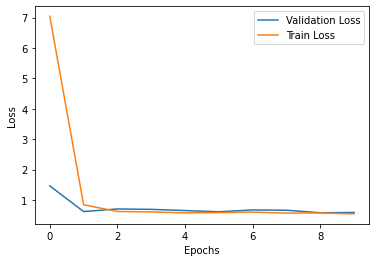

1875/1875 [==============================] - 205s 109ms/step - loss: 0.5268 - accuracy: 0.8132
Training accuracy is 81.32166862487793
Test accuracy is 78.86999845504761


In [ ]:

with open('ResNet50V2Classifier.pkl','rb') as data:
  trackLossClasifierResNet50V2 = pickle.load(data)
plt.plot(trackLossClasifierResNet50V2['val_loss'])
plt.plot(trackLossClasifierResNet50V2['loss'])
plt.legend(['Validation Loss', 'Train Loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()
modResNet50V2 = load_model("ResNet50V2Classifier.h5")
val_ResNet50V2 = (modResNet50V2.evaluate(x_test_final,y_test_labelled))[1]*100
print("Training accuracy is "+str((modResNet50V2.evaluate(x_train_final,y_train_labelled))[1]*100))
print("Test accuracy is "+str(val_ResNet50V2))

#MobileNet

In [ ]:

modMobileNet = Sequential()
modMobileNet.add(MobileNet(include_top=False,weights='imagenet',input_shape=(56,56, 3)))
for i in range(len(modMobileNet.layers)):
  modMobileNet.layers[i].trainable = False
print(modMobileNet.summary())
modMobileNet.add(Flatten())
modMobileNet.add(Dense(128, activation='relu'))
modMobileNet.add(Dense(64, activation='relu'))
modMobileNet.add(Dense(10, activation='softmax'))
print(modMobileNet.summary())
modMobileNet.compile(optimizer = 'adam',loss="categorical_crossentropy",metrics=['accuracy'])


Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 1, 1, 1024)       3228864   
 nal)                                                            
                                                                 
Total params: 3,228,864
Trainable params: 0
Non-trainable params: 3,228,864
_________________________________________________________________
None
Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 1, 1, 1024)       3228864   
 nal)                                                            
                                                                 
 flatten_9 (Flatten)         (None, 1024)              0         
                                                                 
 dense_27 (Dens

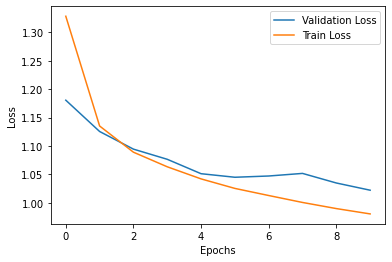

1875/1875 [==============================] - 120s 64ms/step - loss: 0.9794 - accuracy: 0.6532
Training accuracy is 65.3166651725769
Test accuracy is 63.099998235702515


In [ ]:

with open('MobileNetClassifier.pkl','rb') as data:
  trackLossClasifierMobileNet = pickle.load(data)
plt.plot(trackLossClasifierMobileNet['val_loss'])
plt.plot(trackLossClasifierMobileNet['loss'])
plt.legend(['Validation Loss', 'Train Loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()
modMobileNet = load_model("MobileNetClassifier.h5")
val_MobileNet = (modMobileNet.evaluate(preprocess_input(x_test_final),y_test_labelled))[1]*100
print("Training accuracy is "+str((modMobileNet.evaluate(preprocess_input(x_train_final),y_train_labelled))[1]*100))
print("Test accuracy is "+str(val_MobileNet))

#EfficientNetB0

In [ ]:


from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense

# Initialize a sequential model in Keras
modEfficientNetB0 = Sequential()

# Add the EfficientNetB0 model with pretrained weights from ImageNet, and freeze all of its layers
modEfficientNetB0.add(EfficientNetB0(include_top=False,weights='imagenet',input_shape=(56,56, 3)))
for i in range(len(modEfficientNetB0.layers)):
    modEfficientNetB0.layers[i].trainable = False
    
# Print a summary of the model architecture
print(modEfficientNetB0.summary())

# Add a flattening layer to convert the output of the EfficientNetB0 model into a 1D array
modEfficientNetB0.add(Flatten())

# Add a fully connected layer with 128 neurons and ReLU activation
modEfficientNetB0.add(Dense(128, activation='relu'))

# Add a second fully connected layer with 64 neurons and ReLU activation
modEfficientNetB0.add(Dense(64, activation='relu'))

# Add a final fully connected layer with 10 neurons and softmax activation
modEfficientNetB0.add(Dense(10, activation='softmax'))

# Print a summary of the model architecture
print(modEfficientNetB0.summary())

# Compile the model using the Adam optimizer, categorical crossentropy loss, and accuracy as a metric
modEfficientNetB0.compile(optimizer = 'adam',loss="categorical_crossentropy",metrics=['accuracy'])



Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 2, 2, 1280)       4049571   
                                                                 
Total params: 4,049,571
Trainable params: 0
Non-trainable params: 4,049,571
_________________________________________________________________
None
Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 2, 2, 1280)       4049571   
                                                                 
 flatten_10 (Flatten)        (None, 5120)              0         
                                                                 
 dense_30 (Dense)            (None, 128)               655488    
                                                                 
 dense_31 (Dens

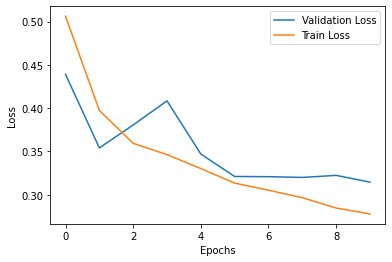

1875/1875 [==============================] - 301s 161ms/step - loss: 0.2578 - accuracy: 0.9041
Training accuracy is 90.41333198547363
Test accuracy is 87.80999779701233


In [ ]:

with open('EfficientNetB0Classifier.pkl','rb') as data:
  trackLossClasifierEfficientNetB0 = pickle.load(data)

plt.plot(trackLossClasifierEfficientNetB0['val_loss'])
plt.plot(trackLossClasifierEfficientNetB0['loss'])
plt.legend(['Validation Loss', 'Train Loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()
modEfficientNetB0.load_weights("EfficientNetB0Classifier.h5")
val_EfficientNetB0 = (modEfficientNetB0.evaluate(x_test_final,y_test_labelled))[1]*100
print("Training accuracy is "+str((modEfficientNetB0.evaluate(x_train_final,y_train_labelled))[1]*100))
print("Test accuracy is "+str(val_EfficientNetB0))

In [ ]:
print("The accuracy for VGG16 "+str(val_vgg16))
print("The accuracy for VGG19 "+str(val_vgg19))
print("The accuracy for ResNet50V2 "+str(val_ResNet50V2))
print("The accuracy for MobileNet "+str(val_MobileNet))
print("The accuracy for EfficientNetB0 "+str(val_EfficientNetB0))

The accuracy for VGG16 82.81000256538391
The accuracy for VGG19 82.81999826431274
The accuracy for ResNet50V2 78.86999845504761
The accuracy for MobileNet 63.099998235702515
The accuracy for EfficientNetB0 87.80999779701233
